# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [1]:
import pandas as pd
from IPython.display import display, HTML

data = pd.read_csv('Advertising.csv')
display(data.head())
display(HTML(f"<u>Shape:</u> {data.shape}"))


,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [2]:
data.isna().sum()


Unnamed: 0    0
TV            0
radio         0
newspaper     0
sales         0
dtype: int64

**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [3]:
data.drop(['Unnamed: 0'], inplace=True, axis=1)

target_column = 'sales'
data_features = data.drop([target_column], axis=1)
data_target = data[target_column]

X = data_features.to_numpy(copy=True)
y = data_target.to_numpy(copy=True)
print(f"X: type={type(X)}, shape={X.shape}")
print(f"y: type={type(y)}, shape={y.shape}")


X: type=<class 'numpy.ndarray'>, shape=(200, 3)
y: type=<class 'numpy.ndarray'>, shape=(200,)


## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [4]:
import numpy as np

X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
print(f"X: type={type(X)}, shape={X.shape}")
X[0:4, :]


X: type=<class 'numpy.ndarray'>, shape=(200, 4)


array([[  1. , 230.1,  37.8,  69.2],
       [  1. ,  44.5,  39.3,  45.1],
       [  1. ,  17.2,  45.9,  69.3],
       [  1. , 151.5,  41.3,  58.5]])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [5]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))
X[0:4, :]


array([[0.07071068, 0.09561706, 0.09692057, 0.13052034],
       [0.07071068, 0.01849178, 0.10076663, 0.08506456],
       [0.07071068, 0.00714739, 0.11768927, 0.13070895],
       [0.07071068, 0.06295517, 0.1058947 , 0.11033873]])

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [6]:
import numpy as np
from typing import Callable
from IPython.display import display, HTML

RATIO_GOLDEN = (1 + 5 ** 0.5) / 2
INV_RATIO_GOLDEN = 1 / RATIO_GOLDEN
INV_RATIO_GOLDEN_SQUARED = 1 - 1 / RATIO_GOLDEN  # == 1 / RATIO_GOLDEN**2
LOG_INV_RATIO_GOLDEN = np.log(INV_RATIO_GOLDEN)


def array_put(x: np.ndarray, i: int, xi: float):
    x[i] = xi
    return x


def optimize_golden_section(f: Callable, a: float, b: float, tol: float = 1e-5):
    assert a < b
    assert tol > 0
    assert tol < 1

    h = b - a
    x_left = a + INV_RATIO_GOLDEN_SQUARED * h
    x_right = a + INV_RATIO_GOLDEN * h
    f_left = f(x_left)
    f_right = f(x_right)
    number_of_iterations = int(
        np.ceil((np.log(tol) - np.log(h)) / LOG_INV_RATIO_GOLDEN))

    for i in range(number_of_iterations - 1):
        h = INV_RATIO_GOLDEN * h
        if f_left >= f_right:
            a = x_left  # ; b = b
            x_left = x_right
            f_left = f_right
            x_right = a + INV_RATIO_GOLDEN * h
            f_right = f(x_right)
        else:
            b = x_right  # ; a = a
            x_right = x_left
            f_right = f_left
            x_left = a + INV_RATIO_GOLDEN_SQUARED * h
            f_left = f(x_left)

    if f_left >= f_right:
        return {
            'point': (x_left + b) / 2,
            'uncertainty': (x_left, b),
            'tol': b - x_left,
            'iterations': number_of_iterations
        }
    else:
        return {
            'point': (a + x_right) / 2,
            'uncertainty': (a, x_right),
            'tol': x_right - a,
            'iterations': number_of_iterations
        }


def interval_1d(f: Callable, x0, dx):
    assert dx > 0
    x = x0
    a = x
    f_a = f(a)

    f_x_dx = f(x - dx)
    if f_x_dx < f_a:
        dx = -dx

    b = x + dx
    f_b = f(b)

    temp_a = a
    while f_b < f_a:
        temp_a = a
        a = b
        f_a = f_b
        b = b + dx
        f_b = f(b)

    a = temp_a

    if dx < 0:
        temp_b = b
        b = a
        a = temp_b

    return (a, b)


def optimize_coordinate_descent(f: Callable, x0: np.ndarray,
                                tol: float = 1e-5,
                                iterations=1000, iterations_over_tolerance: bool = False,
                                sliding_window_1d: float = 0.01,
                                norm_order: int = 2):
    assert isinstance(x0, np.ndarray)
    assert len(np.shape(x0)) == 1
    assert tol > 0
    assert tol < 1

    p = np.size(x0)
    x_last = np.copy(x0, order='C')
    x = np.copy(x0, order='C')
    counter_iterations = 1
    counter_1d_iterations = 0
    while True:
        x = np.copy(x_last, order='C')

        for i in range(p):
            def f_xi(xi): return f(array_put(x, i, xi))
            a_i, b_i = interval_1d(f_xi, x[i], dx=sliding_window_1d)
            result_i = optimize_golden_section(f_xi, a_i, b_i, tol=tol/10)
            xi_new = result_i['point']
            counter_1d_iterations += result_i['iterations']
            x[i] = xi_new

        if iterations_over_tolerance:
            if counter_iterations >= iterations:
                break
        else:
            if np.linalg.norm(x - x_last, ord=norm_order) < tol or counter_iterations >= iterations:
                break

        x_last = x
        counter_iterations += 1

    return {
        'point': x,
        'f': f(x),
        'tol': np.linalg.norm(x - x_last, ord=norm_order),
        'iterations': counter_iterations,
        '1D-iterations': counter_1d_iterations
    }


def optimize_lls_coordinate_descent(X: np.ndarray, y: np.ndarray, w0: np.ndarray,
                                    tol: float = 1e-5,
                                    iterations=1000, iterations_over_tolerance: bool = False,
                                    norm_order: int = 2):
    assert isinstance(w0, np.ndarray)
    assert len(np.shape(w0)) == 1
    assert tol > 0
    assert tol < 1

    p = np.size(w0)
    w_last = np.copy(w0, order='C')
    w = np.copy(w0, order='C')
    counter_iterations = 1
    r = np.zeros(np.size(y))
    while True:
        r = y - X @ w

        for j in range(p):
            r_j = r + w[j] * X[:, j]
            w[j] = r_j @ X[:, j]
            r = r_j - w[j] * X[:, j]

        if iterations_over_tolerance:
            if counter_iterations >= iterations:
                break
        else:
            if np.linalg.norm(w - w_last, ord=norm_order) < tol or counter_iterations >= iterations:
                break

        w_last = np.copy(w, order='C')
        counter_iterations += 1

    return {
        'weights': w,
        'residue': np.dot(r, r),
        'tol': np.linalg.norm(w - w_last, ord=norm_order),
        'iterations': counter_iterations
    }


# /----- Целевая функция -----\
def rss_function(X, y, w):
    delta_y = y - X @ w
    return np.dot(delta_y, delta_y)
# \----- Целевая функция -----/


# /----- Тестовые функции -----\
# X0 = np.array([5.0, 5.0])
def func(X):
    return (X[0] - 1)**2 + (X[1] + 2)**2 + 3


# Для функции Исома метод покоординатного спуска работает плохо.
# X0 = np.array([2.0, 2.0]) # подобранная начальная точка
def easom_function(X):
    return - np.cos(X[0]) * np.cos(X[1]) * np.exp(- (X[0] - np.pi)**2 - (X[1] - np.pi)**2)

# a, b = interval_1d(lambda xi: func(array_put(X0, 0, xi)), X0[0], 0.01)
# print(a, b)
# optimize_golden_section(lambda xi: func(array_put(X0, 0, xi)), a, b, tol=1e-4)
# \----- Тестовые функции -----/

# ==========
w0 = np.zeros(np.size(X, axis=1))
generic_method_results = optimize_coordinate_descent(
    lambda w: rss_function(X, y, w), w0,
    tol=1e-8,
    iterations=1000, iterations_over_tolerance=True,
    sliding_window_1d=0.01, norm_order=2
)
display(HTML(f"<u>Results of the <b><i>generic</i></b> coordinate descent method:</u>"))
display(HTML(f"""<ul>
    <li>Linear regression coefficients <b>w = {{{', '.join(map(str, generic_method_results['point']))}}}</b></li>
    <li>RSS function minimum: <b>{generic_method_results['f']:.3f}</b></li>
    <li>Reached tolerance: <b>{generic_method_results['tol']:e}</b></li>
    <li>Coordinate descent iterations: <b>{generic_method_results['iterations']}</b></li>
    <li>Total 1D iterations: <b>{generic_method_results['1D-iterations']}</b></li>
</ul>"""))
# ==========

# ==========
w0 = np.zeros(np.size(X, axis=1))
lls_method_results = optimize_lls_coordinate_descent(
    X, y, w0, tol=1e-8,
    iterations=1000, iterations_over_tolerance=True,
    norm_order=2
)
display(HTML(f"<u>Results of the <b><i>LLS</i></b>-optimized coordinate descent method:</u>"))
display(HTML(f"""<ul>
    <li>Linear regression coefficients <b>w = {{{', '.join(map(str, lls_method_results['weights']))}}}</b></li>
    <li>RSS function minimum: <b>{lls_method_results['residue']:.3f}</b></li>
    <li>Reached tolerance: <b>{lls_method_results['tol']:e}</b></li>
    <li>Coordinate descent iterations: <b>{lls_method_results['iterations']}</b></li>
</ul>"""))
# ==========

Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print(model.coef_)

display(HTML(f"<u>Results of the <b><i>scikit-learn LinearRegression</i></b> model:</u>"))
display(HTML(f"""<ul>
    <li>Linear regression coefficients <b>w = {{{', '.join(map(str, model.coef_))}}}</b></li>
</ul>"""))

[ 41.56217205 110.13144155  73.52860638  -0.55006384]


Если вы все сделали верно, они должны практически совпасть!

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [8]:
X = data_features.to_numpy(copy=True)
y = data_target.to_numpy(copy=True)

X = ( (X.T - np.mean(X, axis=0)[:, None]) / np.std(X[:, None], axis=0).T ).T


print(f"X[shape={X.shape}] =\n{X[0:5, :]}\n...\n{X[-3:-1, :]}")
print('')
print(f"y[shape={y.shape}] =\n{y[0:5]}... {y[-3:-1]}")


X[shape=(200, 3)] =
[[ 0.96985227  0.98152247  1.77894547]
 [-1.19737623  1.08280781  0.66957876]
 [-1.51615499  1.52846331  1.78354865]
 [ 0.05204968  1.21785493  1.28640506]
 [ 0.3941822  -0.84161366  1.28180188]]
...
[[ 0.34981006 -0.942899   -1.11185242]
 [ 1.59456522  1.26512143  1.64085003]]

y[shape=(200,)] =
[22.1 10.4  9.3 18.5 12.9]... [12.8 25.5]


**Добавим единичный столбец**

In [9]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

print(f"X[shape={X.shape}] =\n{X[0:5, :]}\n...\n{X[-3:-1, :]}")

X[shape=(200, 4)] =
[[ 1.          0.96985227  0.98152247  1.77894547]
 [ 1.         -1.19737623  1.08280781  0.66957876]
 [ 1.         -1.51615499  1.52846331  1.78354865]
 [ 1.          0.05204968  1.21785493  1.28640506]
 [ 1.          0.3941822  -0.84161366  1.28180188]]
...
[[ 1.          0.34981006 -0.942899   -1.11185242]
 [ 1.          1.59456522  1.26512143  1.64085003]]


**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [10]:
def mse_error(y_test: np.ndarray, y_pred: np.ndarray) -> float:
    assert np.size(y_test) == np.size(y_pred)
    return (1 / np.size(y_test)) * np.sum( (y_test - y_pred)**2 )

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [11]:
y_mean = np.mean(y)
y_means = np.full(np.size(y), y_mean)

display(HTML(f"<span style='color: red'><b>MSE</b> of mean value: <b>{mse_error(y_means, y):.3f}</b></span>"))

**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [12]:
# ваш код
def lin_pred(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    assert X.ndim == 2
    assert w.ndim == 1
    assert np.size(X, axis=1) == np.size(w, axis=0)
    print(X[0:5, :])
    return X @ w

# ==========
# Сделаем градиентный спуск generic методом для функции RSS
# для самопроверки, что величина MSE будет меньше
# по сравнению с MSE, подсчитаной по среднему значению продаж.
# ==========
w0 = np.zeros(np.size(X, axis=1))
generic_method_results = optimize_coordinate_descent(
    lambda w: rss_function(X, y, w), w0,
    tol=1e-8,
    iterations=1000, iterations_over_tolerance=True,
    sliding_window_1d=0.01, norm_order=2
)
y_pred = lin_pred(X, generic_method_results['point'])
display(HTML(f"<u>Results of the <b><i>generic</i></b> coordinate descent method:</u>"))
display(HTML(f"""<ul>
    <li>Linear regression coefficients <b>w = {{{', '.join(map(str, np.round(generic_method_results['point'], 3)))}}}</b></li>
    <li>RSS function minimum: <b>{generic_method_results['f']:.3f}</b></li>
    <li>Reached tolerance: <b>{generic_method_results['tol']:e}</b></li>
    <li>Coordinate descent iterations: <b>{generic_method_results['iterations']}</b></li>
    <li>Total 1D iterations: <b>{generic_method_results['1D-iterations']}</b></li>
    <li><span style='color: red'><b>MSE</b> of LLS coordinate descent: <b>{mse_error(y_pred, y):.3f}</b></span></li>
</ul>"""))
# ==========

[[ 1.          0.96985227  0.98152247  1.77894547]
 [ 1.         -1.19737623  1.08280781  0.66957876]
 [ 1.         -1.51615499  1.52846331  1.78354865]
 [ 1.          0.05204968  1.21785493  1.28640506]
 [ 1.          0.3941822  -0.84161366  1.28180188]]


**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [13]:
def stoch_grad_step(X: np.ndarray, y: np.ndarray, w: np.ndarray, train_ind: int, eta: float) -> np.ndarray:
    return w - (2 * eta) * X[train_ind, :] * (X[train_ind, :] @ w - y[train_ind])

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм следующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте оновной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [14]:
def stochastic_gradient_descent(
    X: np.ndarray, y: np.ndarray, w0: np.ndarray,
    eta_rate: float = 0.05,
    iterations: int = 1000, iterations_over_tolerance: bool = False,
    tol: float = 1e-5) -> np.ndarray:
    assert X.ndim == 2
    assert y.ndim == 1
    assert w0.ndim == 1
    assert np.size(X, axis=0) == np.size(y, axis=0)
    assert np.size(X, axis=1) == np.size(w0, axis=0)
    assert eta_rate > 0
    assert iterations > 0
    assert tol > 0

    # =====
    w = np.copy(w0)
    w_last = np.copy(w0 + 1000)
    N = np.size(X, axis=0)
    counter_iterations = 1
    # -----
    error_list = list()
    # -----
    while True:
        train_ind = np.random.randint(low=0, high=N)
        w = stoch_grad_step(X, y, w, train_ind=train_ind, eta=eta_rate)

        error = mse_error(y_test=y, y_pred=X @ w)
        error_list.append(error)

        if iterations_over_tolerance:
            if counter_iterations >= iterations:
                break
        else:
            if np.linalg.norm(w - w_last, ord=2) < tol or counter_iterations >= iterations:
                break

        w_last = np.copy(w)
        counter_iterations += 1
    # =====
    
    return {
        'weights': w,
        'errors': np.array(error_list),
        'last_error': error_list[-1],
        'tol': np.linalg.norm(w - w_last, ord=2),
        'iterations': counter_iterations
    }


 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

**Постройте график зависимости ошибки от номера итерации**

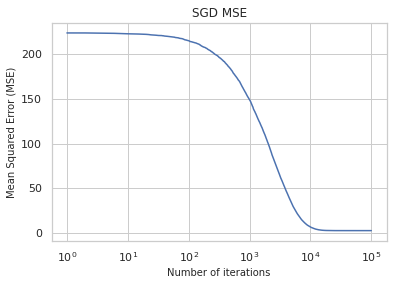

In [15]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_theme(style='whitegrid')


w0 = np.zeros(np.size(X, axis=1))
sgd_results = stochastic_gradient_descent(X, y, w0,
    eta_rate=0.0001,
    iterations=int(1e5), iterations_over_tolerance=True,
    tol=1e-5
)

mse_errors = sgd_results['errors']
mse_errors_plot = sns.lineplot(x=np.arange(1, np.size(mse_errors) + 1), y=mse_errors)
mse_errors_plot.set(xscale='log')
mse_errors_plot.set_xlabel("Number of iterations", fontsize = 10)
mse_errors_plot.set_ylabel("Mean Squared Error (MSE)", fontsize = 10)
mse_errors_plot.set_title("SGD MSE", fontsize = 12)
plt.show(mse_errors_plot)

**Выведите вектор весов, к которому сошелся метод.**

In [16]:
display(HTML(f"<u>Results of the <b><i>Stochatic Gradient Descent</i></b> method:</u>"))
display(HTML(f"""<ul>
    <li><span style='color: blue'>Linear regression coefficients <b>w = {{{', '.join(map(str, np.round(sgd_results['weights'], 3)))}}}</b></span></li>
    <li>MSE errors: <b>[{', '.join(map(str, np.round(sgd_results['errors'][0:5], 5)))}... {', '.join(map(str, np.round(sgd_results['errors'][-4:-1], 5)))}]</b></li>
    <li>Reached tolerance: <b>{sgd_results['tol']:e}</b></li>
    <li>SGD iterations: <b>{sgd_results['iterations']}</b></li>
    <li><span style='color: red'><b>MSE</b> of Stochatic Gradient Descent: <b>{sgd_results['last_error']:.3f}</b></span></li>
</ul>"""))


**Выведите среднеквадратичную ошибку на последней итерации.**

In [17]:
display(HTML(f"<span style='color: darkred'>Last <b>MSE</b> of Stochatic Gradient Descent: <b>{sgd_results['last_error']:.3f}</b></span>"))
